<a href="https://colab.research.google.com/github/bolaris-sage/shark-research/blob/main/shark-analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
In this notebook, we dive into the analysis of a female great white shark, tagged as #A14243, off the coast of Guadalupe Island, Mexico. The data, collected from 15th October to 23nd October 2017, includes readings from pressure, temperature, and a 3-axis accelerometer sensors. This study focuses on interpreting the relationship between her depth, surrounding environmental conditions, and movement behaviors during this period. By utilizing interactive visualization tools, we aim to unravel the complex patterns in her movements, offering insights into shark ecology and aiding marine conservation

## Data Overview
CEFAS 1 Female 4.5
- **Deployment Duration**: October 15, 2017 - October 23, 2017
- **Tag ID**: A14243
- **Firmware**: Version 3, Build Level 70
- **Sensors Count**: 5
- **Sensors**: P T x y z
- **Logging Rate**: 1 per second
- **Resolution**: 12 bits
- **Pressure Range**: 50 units
- **G range selected**: 2g
- **Wet dry logging**: Inhibited
- **Logging of Dive data**: Active
- **Dive Termination**: 1.5% percentage, 7.5m depth

The dataset contains time-stamped measurements of pressure, temperature, and tri-axial acceleration. These metrics are used to assess the shark's movement behavior.

# Analysis

## Import Libraries

In [12]:
# Install Astral (if needed)
%pip install astral

# Standard library imports
from datetime import datetime, timedelta
import os
import sys

# Third-party imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pytz import timezone
from astral import LocationInfo
from astral.sun import sun

from matplotlib.colors import LinearSegmentedColormap

## Data Loading

In [13]:
# Check if the notebook is running on Google Colab
running_on_colab = 'google.colab' in sys.modules

if running_on_colab:
    # Google Colab specific imports
    from google.colab import auth, drive

    # Authenticate and mount the drive
    auth.authenticate_user()
    drive.mount('/content/drive')

    # Set the base path for data on Google Drive
    base_path = '/content/drive/MyDrive/shark-data/'
else:
    # Set the base path for local data
    base_path = 'C:/shared/shark-data/'

# Now you can load your data using the base path
data_file_path = os.path.join(base_path, 'A14243_23-10-2017.csv')

# Load the data
data = pd.read_csv(data_file_path, skiprows=59)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Cleaning

In [14]:
# Convert 'Time Stamp' to datetime and drop rows with invalid dates
initial_count = data.shape[0]
data['Time Stamp'] = pd.to_datetime(data['Time Stamp'], format='%d/%m/%y %H:%M', errors='coerce')

# Combining the conditions for dropping invalid timestamps, pressure, and temperature values
conditions = (data['Time Stamp'].notna()) & \
             (data['Pressure'].notna()) & (data['Pressure'] != np.inf) & (data['Pressure'] != -np.inf) & \
             (data['Temp'].notna()) & (data['Temp'] != np.inf) & (data['Temp'] != -np.inf)

# Create a copy of the data to be dropped for record-keeping
dropped_data = data[~conditions].copy()

# Filter the data based on the combined conditions
data = data[conditions]

# Summary of dropped data
dropped_due_to_timestamp = dropped_data['Time Stamp'].isna().sum()
dropped_due_to_invalid_values = len(dropped_data) - dropped_due_to_timestamp

print(f"Total initial events: {initial_count}")
print(f"Dropped due to invalid timestamps: {dropped_due_to_timestamp}")
print(f"Dropped due to invalid Pressure/Temperature values: {dropped_due_to_invalid_values}")
print(f"Remaining events after cleaning: {data.shape[0]}")

# Display a sample of dropped data for verification
#print("Sample of data dropped:")
#print(dropped_data.head())

Total initial events: 700624
Dropped due to invalid timestamps: 4
Dropped due to invalid Pressure/Temperature values: 0
Remaining events after cleaning: 700620


## Data Transformation

### Calculating ODBA
ODBA is calculated to represent shark's locomotor activity, serving as an energy expenditure proxy.

In [15]:
# Ensure data is a copy to avoid SettingWithCopyWarning
data = data.copy()

# Calculate ODBA as the sum of the absolute values of the dynamic accelerations
#data['ODBA'] = data[['X Axis', 'Y Axis', 'Z Axis']].abs().sum(axis=1)

window_size = 5  # Set the window size for the running mean

# Calculate ODBA as the sum of the absolute values of the dynamic accelerations with running mean subtracted
data['ODBA'] = (data[['X Axis', 'Y Axis', 'Z Axis']] -
                data[['X Axis', 'Y Axis', 'Z Axis']].rolling(window=window_size).mean()).abs().sum(axis=1)

### Calculating Day-Night Cycle Times

In [16]:
# Define the location and timezone for sunrise/sunset calculations
# Guadalupe Island Coordinates
guadalupe_latitude = 29.020879
guadalupe_longitude = -118.273103
city = LocationInfo('Ensenada', 'Mexico', 'America/Tijuana', guadalupe_latitude, guadalupe_longitude)
local_tz = timezone('America/Tijuana')

# Custom function to calculate sunrise and sunset
def calculate_sun_cycles(date):
    s = sun(city.observer, date=date, tzinfo=local_tz)
    return {'sunrise': s['sunrise'].replace(tzinfo=None),
            'sunset': s['sunset'].replace(tzinfo=None)}

# Convert 'Time Stamp' to date if not already done
data['Date'] = data['Time Stamp'].dt.date

# Use groupby and apply to calculate sun cycles
sun_cycles = data.groupby('Date').apply(lambda x: calculate_sun_cycles(x.name)).to_dict()

## Data Visualization

### Depth over Time with Temperature Color Coding and Day/Night Bands
Depth over time graph, with temperature color-coding and day/night bands, illustrates how sharks' movement patterns are influenced by environmental and temporal factors.

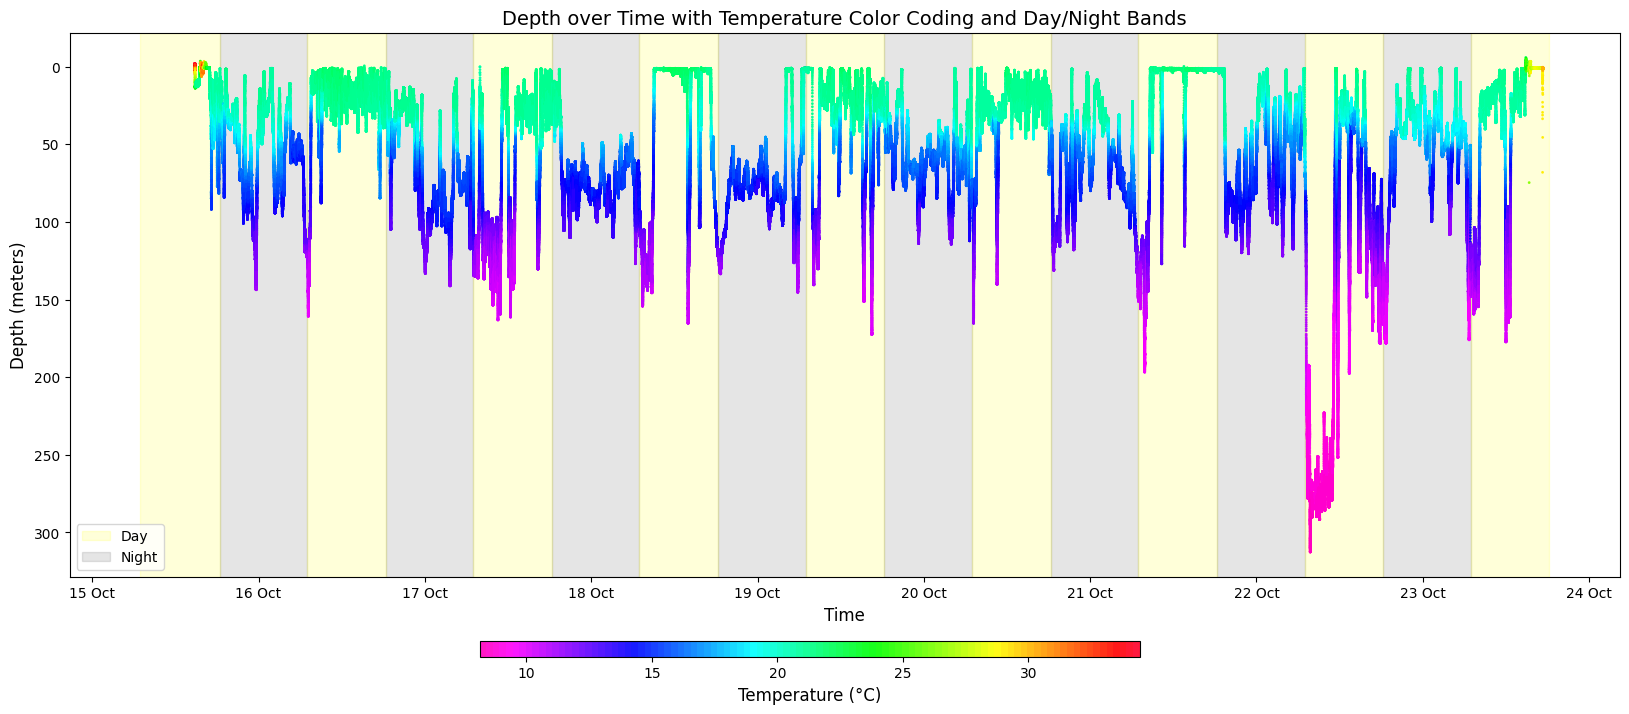

In [17]:
# Initialize plot
plt.figure(figsize=(20, 8))

# Plot day-night bands using the sun_cycles dictionary
for date, times in sun_cycles.items():
    sunrise = times['sunrise']
    sunset = times['sunset']
    plt.axvspan(sunrise, sunset, color='#FFFF00', alpha=0.15, label='Day')

    # Handling the night span
    if date != data['Time Stamp'].dt.date.max():
        next_day_sunrise = sun_cycles[date + timedelta(days=1)]['sunrise']
        plt.axvspan(sunset, next_day_sunrise, color='black', alpha=0.1, label='Night')

# Use a predefined colormap
cmap = plt.get_cmap('gist_rainbow', 100).reversed()
norm = plt.Normalize(vmin=data['Temp'].min(), vmax=data['Temp'].max())

# Plot depth data against time, colored by temperature
sc = plt.scatter(data['Time Stamp'], data['Pressure'], c=data['Temp'], cmap=cmap, norm=norm, s=1, alpha=0.9)
plt.gca().invert_yaxis()

# Format the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))

# Only add the legend for day/night once
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='lower left')

# Set plot titles and labels
plt.title('Depth over Time with Temperature Color Coding and Day/Night Bands', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Depth (meters)', fontsize=12)

# Increase the bottom margin to ensure the colorbar does not overlap with x-axis labels
plt.subplots_adjust(bottom=0.20)

# Adjust the position of the colorbar
colorbar_axes = plt.gcf().add_axes([0.33, 0.1, 0.33, 0.02])

# Create the colorbar with the specified axes and orientation
cbar = plt.colorbar(sc, cax=colorbar_axes, orientation='horizontal')

# Set the label for the colorbar
cbar.set_label('Temperature (°C)', fontsize=12)

# Show the plot
plt.show()

### ODBA over Time with Day/Night Bands
The graph shows sharks' Overall Dynamic Body Acceleration (ODBA) over time, marked with day (yellow) and night (black) bands.

<ipython-input-21-81a10dd05562>:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  resampled_data = data.resample('min', on='Time Stamp').mean()


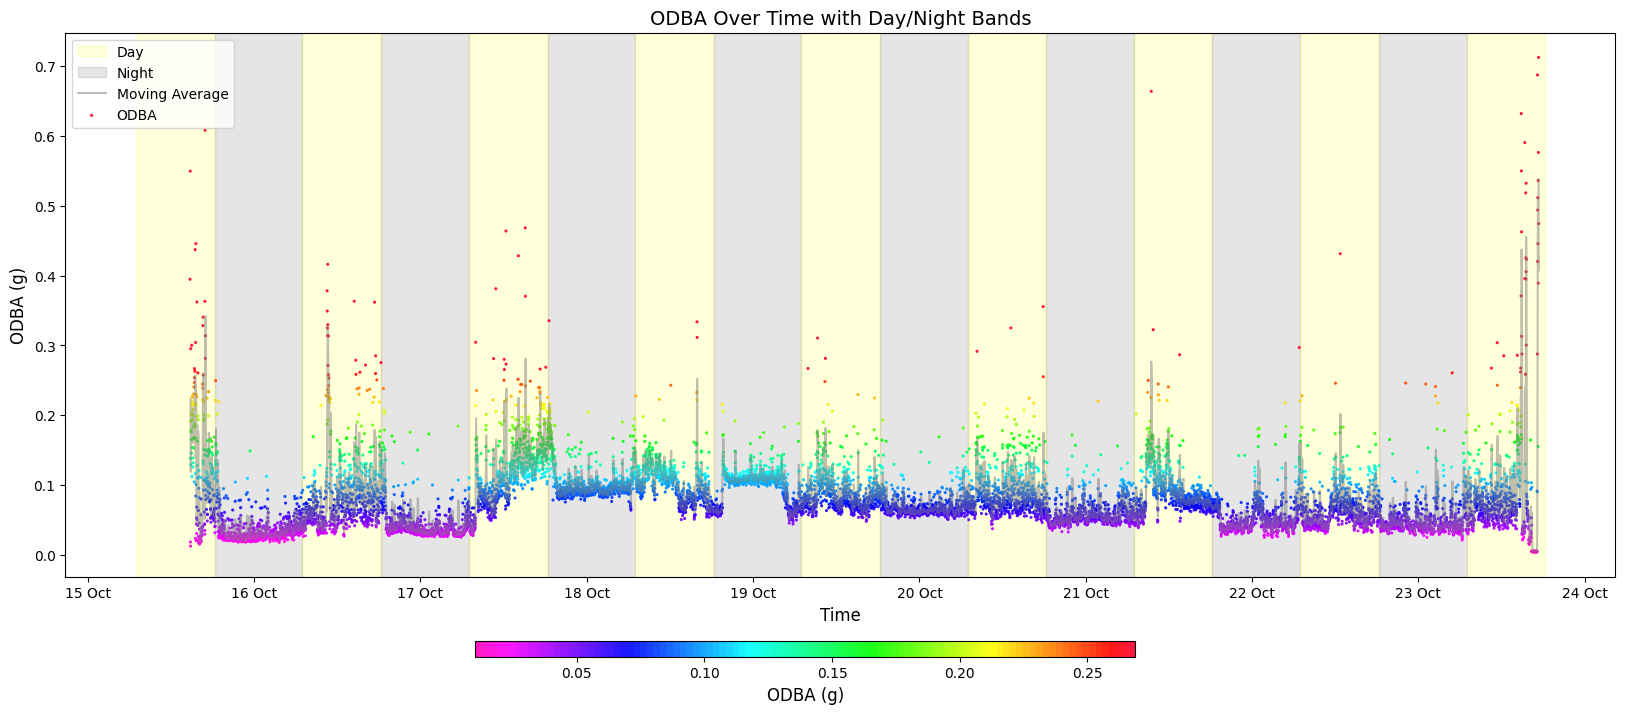

In [21]:
# Initialize plot
plt.figure(figsize=(20, 8))

# Plot day-night bands using the sun_cycles dictionary
for date, times in sun_cycles.items():
    sunrise = times['sunrise']
    sunset = times['sunset']
    plt.axvspan(sunrise, sunset, color='#FFFF00', alpha=0.15, label='Day')

    # Handling the night span
    if date != data['Time Stamp'].dt.date.max():
        next_day_sunrise = sun_cycles[date + timedelta(days=1)]['sunrise']
        plt.axvspan(sunset, next_day_sunrise, color='black', alpha=0.1, label='Night')

resampled_data = data.resample('min', on='Time Stamp').mean()


# Calculate the moving average of ODBA with a window size
window_size = 5
odba_moving_average = resampled_data['ODBA'].rolling(window=window_size).mean()

# Plot the moving average ODBA line
plt.plot(resampled_data.index, odba_moving_average, color='grey', alpha=0.5, label='Moving Average')

cmap = plt.get_cmap('gist_rainbow', 100).reversed()
lower_percentile = 2
upper_percentile = 98
lower_bound = data['ODBA'].quantile(lower_percentile / 100)
upper_bound = data['ODBA'].quantile(upper_percentile / 100)
norm = plt.Normalize(vmin=lower_bound, vmax=upper_bound)

# Scatter plot for ODBA values over time
sc = plt.scatter(resampled_data.index, resampled_data['ODBA'], s=5, alpha=0.9,
                      c=resampled_data['ODBA'], cmap=cmap, norm=norm, edgecolor='none', label='ODBA')

# Format the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))

# Only add the legend for day/night once
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper left')

# Set plot titles and labels
plt.title('ODBA Over Time with Day/Night Bands', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('ODBA (g)', fontsize=12)

# Increase the bottom margin to ensure the colorbar does not overlap with x-axis labels
plt.subplots_adjust(bottom=0.20)

# Adjust the position of the colorbar
colorbar_axes = plt.gcf().add_axes([0.33, 0.1, 0.33, 0.02])

# Create the colorbar with the specified axes and orientation
cbar = plt.colorbar(sc, cax=colorbar_axes, orientation='horizontal')

# Set the label for the colorbar
cbar.set_label('ODBA (g)', fontsize=12)

# Show the plot
plt.show()

### Depth over Time with ODBA Color Coding

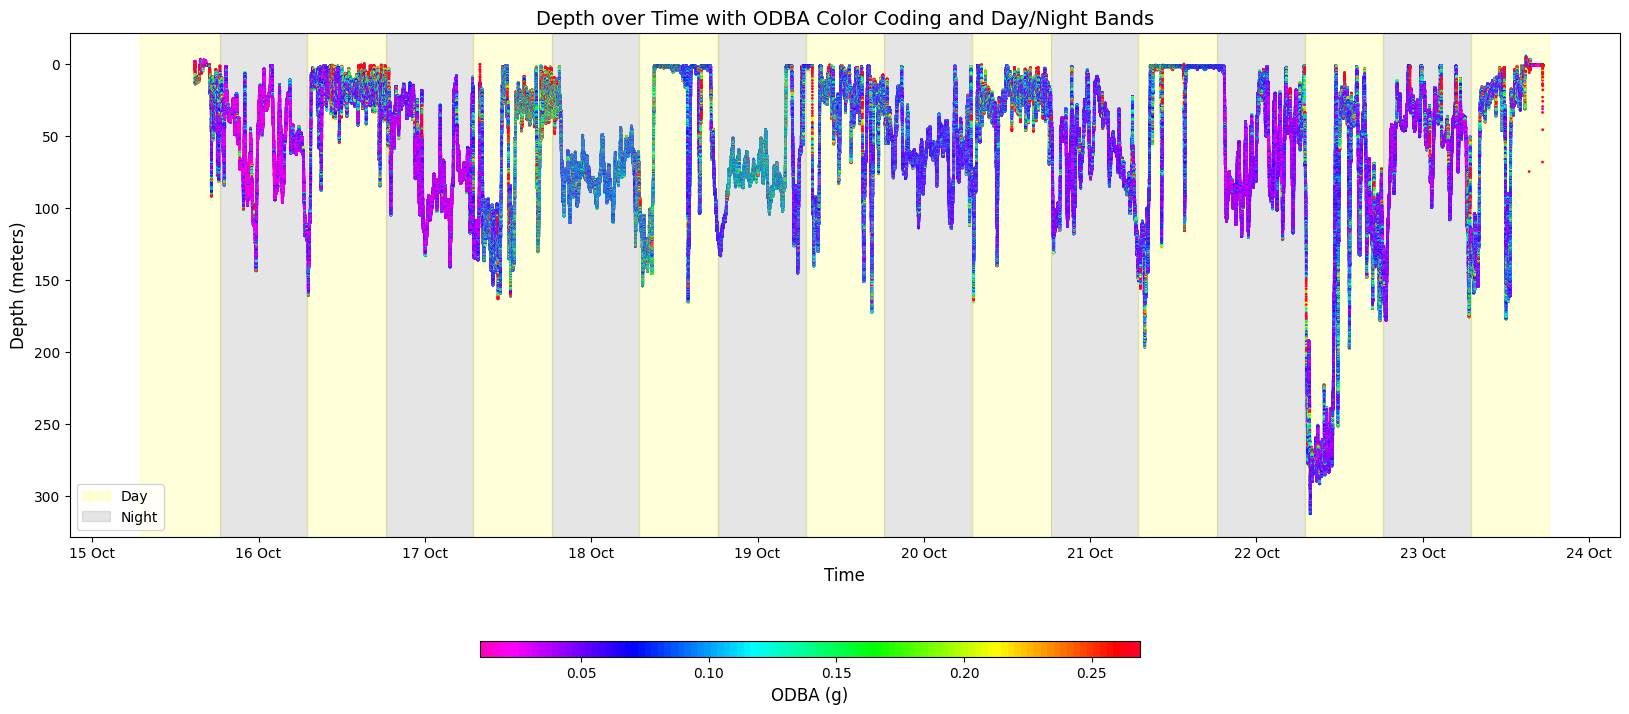

In [19]:
# Initialize plot
plt.figure(figsize=(20, 8))

# Plot day-night bands using the sun_cycles dictionary
for date, times in sun_cycles.items():
    sunrise = times['sunrise']
    sunset = times['sunset']
    plt.axvspan(sunrise, sunset, color='#FFFF00', alpha=0.15, label='Day')

    # Handling the night span
    if date != data['Time Stamp'].dt.date.max():
        next_day_sunrise = sun_cycles[date + timedelta(days=1)]['sunrise']
        plt.axvspan(sunset, next_day_sunrise, color='black', alpha=0.1, label='Night')

# Use a predefined colormap
cmap = plt.get_cmap('gist_rainbow', 100).reversed()
lower_percentile = 2
upper_percentile = 98
lower_bound = data['ODBA'].quantile(lower_percentile / 100)
upper_bound = data['ODBA'].quantile(upper_percentile / 100)
norm = plt.Normalize(vmin=lower_bound, vmax=upper_bound)

# Plot depth data against time, colored by temperature
sc = plt.scatter(data['Time Stamp'], data['Pressure'], c=data['ODBA'], cmap=cmap, norm=norm, s=1, alpha=1.0)
plt.gca().invert_yaxis()

# Format the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))

# Only add the legend for day/night once
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='lower left')

# Set plot titles and labels
plt.title('Depth over Time with ODBA Color Coding and Day/Night Bands', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Depth (meters)', fontsize=12)

# Increase the bottom margin to ensure the colorbar does not overlap with x-axis labels
plt.subplots_adjust(bottom=0.25)

# Adjust the position of the colorbar
colorbar_axes = plt.gcf().add_axes([0.33, 0.1, 0.33, 0.02])

# Create the colorbar with the specified axes and orientation
cbar = plt.colorbar(sc, cax=colorbar_axes, orientation='horizontal')

# Set the label for the colorbar
cbar.set_label('ODBA (g)', fontsize=12)

# Show the plot
plt.show()

### Axis Values Over Time with ODBA Color Coding

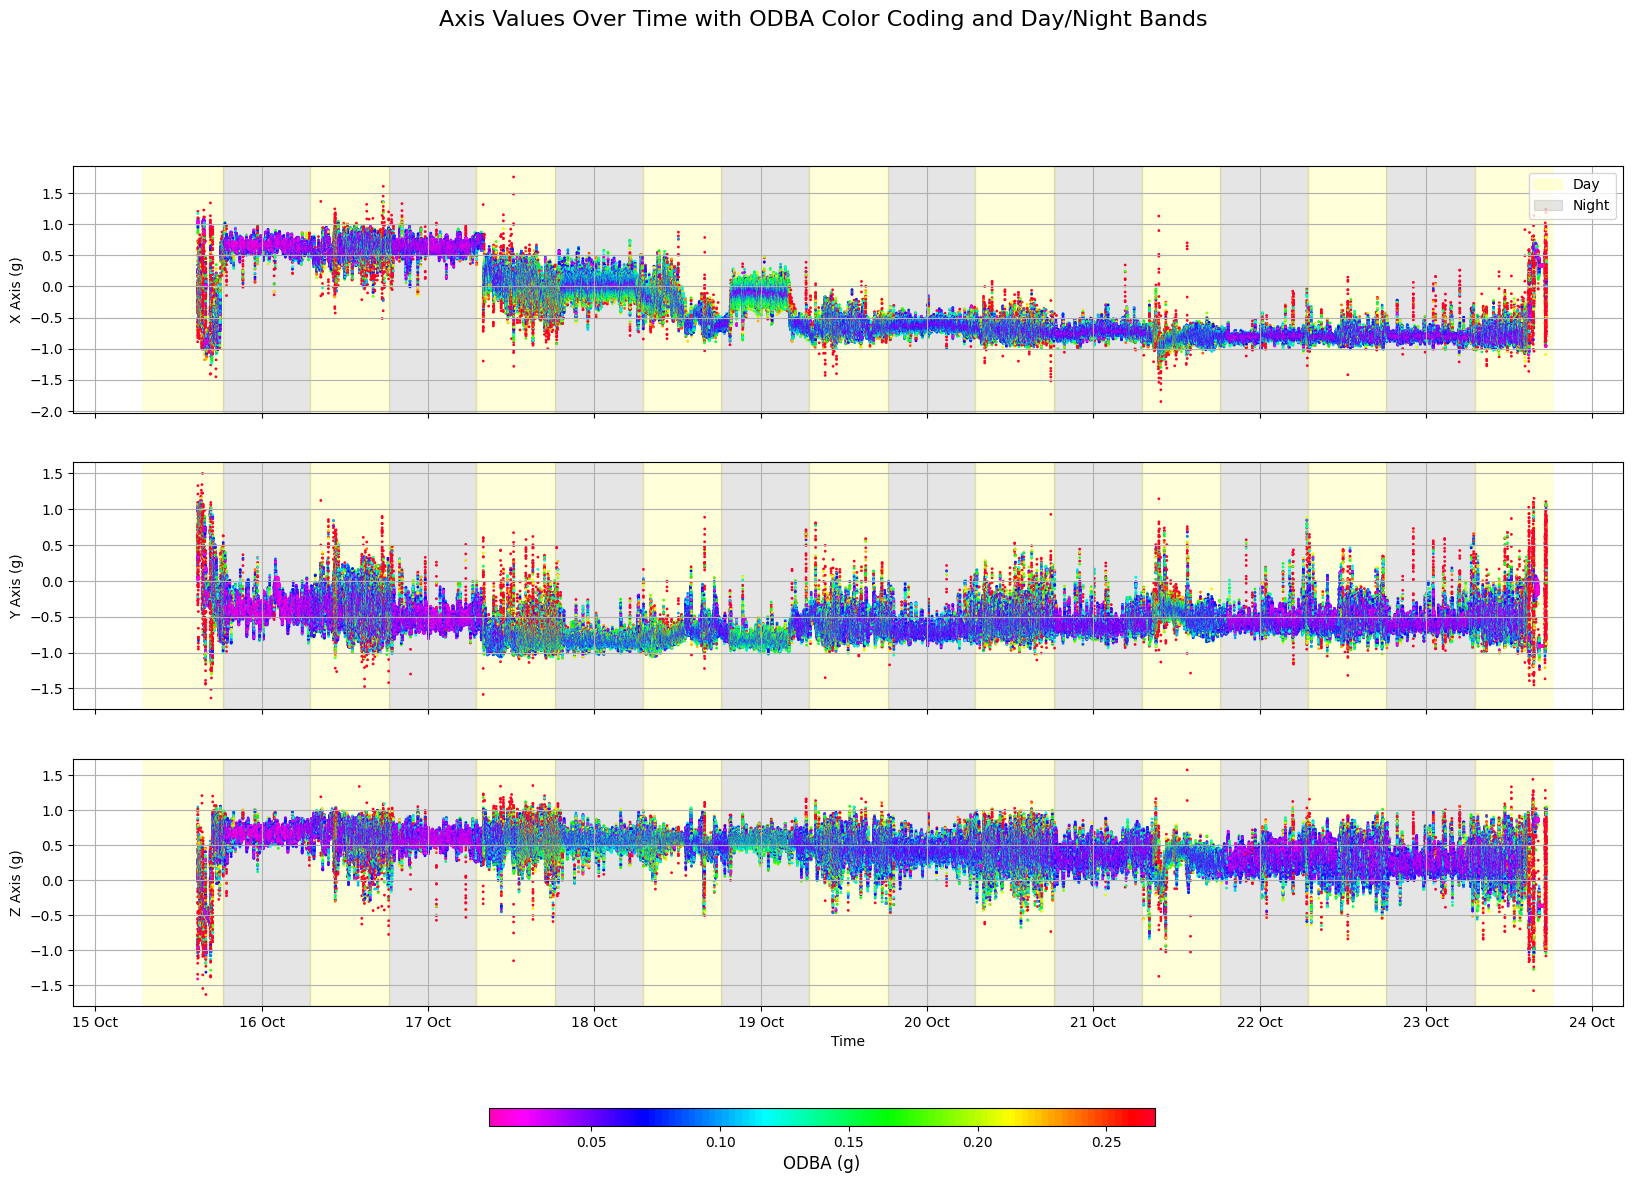

In [20]:
# Create a subplot layout
fig, axs = plt.subplots(3, 1, figsize=(20, 12), sharex=True)

# Store the day/night patches for the legend
day_patch = None
night_patch = None

cmap = plt.get_cmap('gist_rainbow', 100).reversed()
lower_percentile = 2
upper_percentile = 98
lower_bound = data['ODBA'].quantile(lower_percentile / 100)
upper_bound = data['ODBA'].quantile(upper_percentile / 100)
norm = plt.Normalize(vmin=lower_bound, vmax=upper_bound)

for i, axis in enumerate(['X Axis', 'Y Axis', 'Z Axis']):
    # Plot day-night bands using the sun_cycles dictionary
    for date, times in sun_cycles.items():
        sunrise = times['sunrise']
        sunset = times['sunset']
        day_patch = axs[i].axvspan(sunrise, sunset, color='#FFFF00', alpha=0.15)
        if date != data['Time Stamp'].dt.date.max():
            next_day_sunrise = sun_cycles[date + timedelta(days=1)]['sunrise']
            night_patch = axs[i].axvspan(sunset, next_day_sunrise, color='black', alpha=0.1)

    # Scatter plot for color-coded temperature data
    sc = axs[i].scatter(data['Time Stamp'], data[axis], c=data['ODBA'], cmap=cmap, norm=norm, s=1, alpha=1.0)

    axs[i].set_ylabel(f'{axis} (g)')
    axs[i].grid(True)

    # Format the x-axis
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    axs[i].xaxis.set_major_locator(mdates.DayLocator(interval=1))

# Add a legend for day and night bands
axs[0].legend([day_patch, night_patch], ['Day', 'Night'], loc='upper right')

# Set common X-Axis properties
axs[-1].set_xlabel('Time')

# Set the title for the entire figure
fig.suptitle('Axis Values Over Time with ODBA Color Coding and Day/Night Bands', fontsize=16)

# Increase the bottom margin to ensure the colorbar does not overlap with x-axis labels
plt.subplots_adjust(bottom=0.20)

# Adjust the position of the colorbar
# These values are fractions of the figure size. (left, bottom, width, height)
colorbar_axes = fig.add_axes([0.333, 0.05, 0.333, 0.015])

# Create the colorbar with the specified axes and orientation
cbar = plt.colorbar(sc, cax=colorbar_axes, orientation='horizontal')
cbar.set_label('ODBA (g)', fontsize=12)

# Set the grid for better readability
for ax in axs:
    ax.grid(True)

# Adjust layout
fig.subplots_adjust(bottom=0.15, top=0.85)

# Show the plot
plt.show()